In [96]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier

from csv import writer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree
import matplotlib.pyplot as plt
import time

import warnings

# Suppress all future warnings
warnings.simplefilter(action='ignore')

designation_grp = [['CEO'],
                   ['CTO'],
                   ['FINANCE MANAGER', 'SALES_MANAGER'],
                   ['HR MANAGER'],
                   ['DESIGNER','PROGRAMMER','SDE','TESTER', 'MTS', 'DATA_ANALYST'],
                   ['PROJECT_MANAGER','SYSTEM_ARCHITECT'],
                   ['PROJECT_LEADER','PRINCIPAL'],
                   ['IT_MANAGER','SECURTY_ENGINEER', 'DEVOPS_ENGINEER'],
                   ['NETWORK_ENGINEER'],
                   ['DATABASE_ENGINEER']
                  ]



resource_grp = [['EMP_DETAIL'],
                ['CLIENT_DETAIL'],
                ['SALARY_DETAIL','PF_DETAIL'],
                ['PROJECT_DETAIL','PROJECT_PLAN'],
                ['NETWORK_SETUP'],
                ['DATABASE'],
                ['PROJECT_COST','ALLOCATED_FUND','FINANCE_REPORT','TAX_DETAIL'],
                ['SERVER','STORAGE','GPU']
               ]

attr_grp={}
attr_grp['DESIGNATION'] = designation_grp
attr_grp['Resource'] = resource_grp


In [97]:
#grp_gap ==> maximum number of allowed attribute values under each group. 
#It is initialized as 20. However, we can provide any value here

# grp is a dict of attribute groups used during mapping/encoding

#map_type == 1 >>> normal encoding
#map_type == 2 >>> encoding based on atrribute group


columns = ['DESIGNATION','Project_name','Department','Experience_level','Resource','Project_name.1','Resource_clearance','Department.1','Access']


def GetAttributeMapping(data,grp=None,grp_gap=20):
    mapping = {
        'NotA': -1,
        0: 0,
        'YES': 1,
        'NO': 0
    }
    if grp is None:
        cnt = 1
        for col in ['DESIGNATION', 'Project_name', 'Department', 'Experience_level', 'Resource', 'Resource_clearance','Project_name.1','Department.1']:
            #print(col,it_full[col].unique())
            col_un = data[col].unique()
            for val in col_un:
                if(val != 'NotA'and val and val not in mapping.keys()):
                    mapping[val] = cnt
                    cnt = cnt + 1
        return mapping
    else:
        cnt = 1
        for col in ['DESIGNATION', 'Project_name', 'Department', 'Experience_level', 'Resource', 'Resource_clearance','Project_name.1','Department.1']:
            #print(col,it_full[col].unique())
            col_un = data[col].unique()
            for val in col_un:
                if(val != 'NotA'):
                    mapping[val] = cnt
                    cnt = cnt + 1
        
        for g in grp:
            grp_num = 1
            for member in grp[g]:
                mem_num = 1
                for val in member:
                    mapping[val] = grp_num*grp_gap+mem_num
                    mem_num = mem_num + 1
                grp_num = grp_num + 1
        return mapping

In [98]:
def same_conditions(col1,col2):
    if ((col1 == -1) or (col2 == -1)):
        return 2
    elif (col1==col2):
        return 1
    else:
        return 0
def chk_nota(col):
    if(col==-1):
        return 1
    else:
        return 0

In [99]:
def GetPreparedData(train_data,test_data,prep_type=4):
    data = pd.concat([train_data,test_data],axis=0)
    #print(data.columns)
    #exit(0)
    if(prep_type==1):# Naive
        mapping = GetAttributeMapping(data,grp=None)
        print(mapping)
        data_encoded = data.replace(mapping)
    elif(prep_type==2):# ARFE
        mapping = GetAttributeMapping(data,grp=None)
        data_encoded = data.replace(mapping)
        data_encoded['sameProj'] = data_encoded.apply(lambda x: same_conditions(x['Project_name'], x['Project_name.1']), axis=1)
        data_encoded['sameDep'] = data_encoded.apply(lambda x: same_conditions(x['Department'], x['Department.1']), axis=1)
        data_encoded = data_encoded.drop(columns=['Department', 'Department.1', 'Project_name', 'Project_name.1'])
    elif(prep_type==3):# AVC
        mapping = GetAttributeMapping(data,grp=attr_grp)
        data_encoded = data.replace(mapping)
    elif(prep_type==4):# ARFE + AVC
        mapping = GetAttributeMapping(data,grp=attr_grp)
        data_encoded = data.replace(mapping)
        data_encoded['sameProj'] = data_encoded.apply(lambda x: same_conditions(x['Project_name'], x['Project_name.1']), axis=1)
        data_encoded['sameDep'] = data_encoded.apply(lambda x: same_conditions(x['Department'], x['Department.1']), axis=1)
        data_encoded = data_encoded.drop(columns=['Department', 'Department.1', 'Project_name', 'Project_name.1'])
    elif(prep_type==5):#Naive+NACol
        mapping = GetAttributeMapping(data,grp=None)
        data_encoded = data.replace(mapping)
        data_encoded['Proj_NA'] = data_encoded.apply(lambda x: chk_nota(x['Project_name']), axis=1)
        
    
    #X = data_encoded.iloc[:,:-1]
    #y = data_encoded.iloc[:,-1]
    
    X = data_encoded.loc[:, data_encoded.columns != 'Access']
    y = data_encoded.loc[:, data_encoded.columns == 'Access']
    
    X_train = X.head(train_data.shape[0])
    X_test = X.tail(test_data.shape[0])
    y_train = y.head(train_data.shape[0])
    y_test = y.tail(test_data.shape[0])
    #print(X)
    return X_train, X_test, y_train, y_test
        

In [100]:
seed = 42
models_dict = {
    #"SupportVectorMachine": SVC(kernel="linear"),
    #"LogisticRegression": LogisticRegression(solver="saga", n_jobs=-1),
    "ArtificalNeuralNetwork": MLPClassifier(hidden_layer_sizes=30, max_iter=1500, random_state=seed),
    "DL": MLPClassifier(hidden_layer_sizes=30, max_iter=1500, random_state=seed),
    "DecisionTree": DecisionTreeClassifier(random_state=seed),
    #"ExtraTree": ExtraTreeClassifier(),
    "RandomForest": RandomForestClassifier(n_jobs=-1, random_state=seed),
    "ExtraTrees": ExtraTreesClassifier(n_jobs=-1, random_state=seed),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="error", n_jobs=-1),
    #"LightGBM": LGBMClassifier(n_estimators=100, n_jobs=-1),
    #"AdaBoost": AdaBoostClassifier(n_estimators=100, learning_rate=1.0),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, random_state=seed),
}

In [101]:
#Clusering using dbscan and mahalanobis distance
def inv(a):
    return np.linalg.inv(a)

def mahalanobis_distance(x=None, data=None, cov=None):
    x_mu = x - np.mean(data)
    #if cov is singular inverse doesn't exist therefore add a small value to the diagonal
    if(np.linalg.det(cov)==0):
        cov = cov + 0.01*np.eye(cov.shape[0])
        print("Covariance is 0")
    inv_covmat = inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal

import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

def cluster_dbscan_mahalanobis(file1,file2,file3):
    data1 = pd.read_csv(file1)
    data2 = pd.read_csv(file2)
    data3 = pd.read_csv(file3)
    
    #get prepared data
    X1,_,_,_ = GetPreparedData(data1,data1,prep_type=4)
    X2,_,_,_ = GetPreparedData(data2,data2,prep_type=4)
    X3,_,_,_ = GetPreparedData(data3,data3,prep_type=4)
    
    joined_data = pd.concat([X1,X2,X3],axis=0)
    #print correlation matrix of joined data
    print(joined_data.corr())
    print(joined_data.shape)
    #cluster this data
    cov = np.cov(joined_data.T)
    mahalanobis_dist = []
    for ind,row in joined_data.iterrows():
        mahalanobis_dist.append(mahalanobis_distance(row,joined_data,cov))
    mahalanobis_data = pd.DataFrame(mahalanobis_dist,columns=['Mahalanobis'])
    #Dataset column for 1 2 3
    mahalanobis_data['Dataset'] = 0
    mahalanobis_data.loc[0:X1.shape[0],'Dataset'] = 1
    mahalanobis_data.loc[X1.shape[0]:X1.shape[0]+X2.shape[0],'Dataset'] = 2
    mahalanobis_data.loc[X1.shape[0]+X2.shape[0]:,'Dataset'] = 3
    
    #cluster this data
    dbscan = DBSCAN(eps=1.3, min_samples=20).fit(mahalanobis_data)
    #EPS means the maximum distance between two samples for one to be considered as in the neighborhood of the other.
    #Label points vs dataset
    labels = dbscan.labels_
    #find number of points of X1,X2,X3 in each cluster
    dbscan_data = pd.DataFrame(labels,columns=['Cluster'])
    #Dataset column for 1 2 3
    dbscan_data['Dataset'] = 0
    dbscan_data.loc[0:X1.shape[0],'Dataset'] = 1
    dbscan_data.loc[X1.shape[0]:X1.shape[0]+X2.shape[0],'Dataset'] = 2
    dbscan_data.loc[X1.shape[0]+X2.shape[0]:,'Dataset'] = 3
    #join data1,2,3
    data1 = pd.read_csv(file1)
    data2 = pd.read_csv(file2)
    data3 = pd.read_csv(file3)
    joined_data = pd.concat([data1,data2,data3],axis=0)
    joined_data = joined_data.reset_index(drop=True)
    dbscan_data = dbscan_data.join(joined_data, how='outer')
    dbscan_data.to_csv('dbscan_mahalanobis_it.csv',index=False)

In [102]:
cluster_dbscan_mahalanobis('it_c1.csv','it_c2.csv','it_c3.csv')

                    DESIGNATION  Experience_level  Resource  \
DESIGNATION            1.000000          0.019475 -0.044048   
Experience_level       0.019475          1.000000 -0.139336   
Resource              -0.044048         -0.139336  1.000000   
Resource_clearance     0.035401          0.953611 -0.216895   
sameProj              -0.031657         -0.053968 -0.008245   
sameDep                0.013706          0.135256 -0.080816   

                    Resource_clearance  sameProj   sameDep  
DESIGNATION                   0.035401 -0.031657  0.013706  
Experience_level              0.953611 -0.053968  0.135256  
Resource                     -0.216895 -0.008245 -0.080816  
Resource_clearance            1.000000 -0.070087  0.119616  
sameProj                     -0.070087  1.000000  0.218389  
sameDep                       0.119616  0.218389  1.000000  
(731, 6)


In [103]:
def cluster_dbscan_hamming(file1,file2,file3):
    data1 = pd.read_csv(file1)
    data2 = pd.read_csv(file2)
    data3 = pd.read_csv(file3)
    
    #get prepared data
    X1,_,_,_ = GetPreparedData(data1,data1,prep_type=4)
    X2,_,_,_ = GetPreparedData(data2,data2,prep_type=4)
    X3,_,_,_ = GetPreparedData(data3,data3,prep_type=4)
    
    joined_data = pd.concat([X1,X2,X3],axis=0)
    #print correlation matrix of joined data
    print(joined_data.corr())
    print(joined_data.shape)
    #cluster this data
    hamming_dist = []
    for ind,row in joined_data.iterrows():
        hamming_dist.append(np.sum(row))
    hamming_data = pd.DataFrame(hamming_dist,columns=['Hamming'])
    #Dataset column for 1 2 3
    hamming_data['Dataset'] = 0
    hamming_data.loc[0:X1.shape[0],'Dataset'] = 1
    hamming_data.loc[X1.shape[0]:X1.shape[0]+X2.shape[0],'Dataset'] = 2
    hamming_data.loc[X1.shape[0]+X2.shape[0]:,'Dataset'] = 3
    
    #cluster this data
    dbscan = DBSCAN(eps=1.5, min_samples=20).fit(hamming_data)
    #Label points vs dataset
    labels = dbscan.labels_
    #find number of points of X1,X2,X3 in each cluster
    dbscan_data = pd.DataFrame(labels,columns=['Cluster'])
    #Dataset column for 1 2 3
    dbscan_data['Dataset'] = 0
    dbscan_data.loc[0:X1.shape[0],'Dataset'] = 1
    dbscan_data.loc[X1.shape[0]:X1.shape[0]+X2.shape[0],'Dataset'] = 2
    dbscan_data.loc[X1.shape[0]+X2.shape[0]:,'Dataset'] = 3
    #join data1,2,3
    data1 = pd.read_csv(file1)
    data2 = pd.read_csv(file2)
    data3 = pd.read_csv(file3)
    joined_data = pd.concat([data1,data2,data3],axis=0)
    joined_data = joined_data.reset_index(drop=True)
    dbscan_data = dbscan_data.join(joined_data, how='outer')
    dbscan_data.to_csv('dbscan_hamming_it.csv',index=False)
    
cluster_dbscan_hamming('it_c1.csv','it_c2.csv','it_c3.csv')

                    DESIGNATION  Experience_level  Resource  \
DESIGNATION            1.000000          0.019475 -0.044048   
Experience_level       0.019475          1.000000 -0.139336   
Resource              -0.044048         -0.139336  1.000000   
Resource_clearance     0.035401          0.953611 -0.216895   
sameProj              -0.031657         -0.053968 -0.008245   
sameDep                0.013706          0.135256 -0.080816   

                    Resource_clearance  sameProj   sameDep  
DESIGNATION                   0.035401 -0.031657  0.013706  
Experience_level              0.953611 -0.053968  0.135256  
Resource                     -0.216895 -0.008245 -0.080816  
Resource_clearance            1.000000 -0.070087  0.119616  
sameProj                     -0.070087  1.000000  0.218389  
sameDep                       0.119616  0.218389  1.000000  
(731, 6)


In [104]:
#Use K means

from sklearn.cluster import KMeans

def cluster_kmeans_mahalanobis(file1,file2,file3):
    data1 = pd.read_csv(file1)
    data2 = pd.read_csv(file2)
    data3 = pd.read_csv(file3)
    
    #get prepared data
    X1,_,_,_ = GetPreparedData(data1,data1,prep_type=4)
    X2,_,_,_ = GetPreparedData(data2,data2,prep_type=4)
    X3,_,_,_ = GetPreparedData(data3,data3,prep_type=4)
    
    joined_data = pd.concat([X1,X2,X3],axis=0)
    #print correlation matrix of joined data
    print(joined_data.corr())
    print(joined_data.shape)
    #cluster this data
    cov = np.cov(joined_data.T)
    mahalanobis_dist = []
    for ind,row in joined_data.iterrows():
        mahalanobis_dist.append(mahalanobis_distance(row,joined_data,cov))
    mahalanobis_data = pd.DataFrame(mahalanobis_dist,columns=['Mahalanobis'])
    #Dataset column for 1 2 3
    mahalanobis_data['Dataset'] = 0
    mahalanobis_data.loc[0:X1.shape[0],'Dataset'] = 1
    mahalanobis_data.loc[X1.shape[0]:X1.shape[0]+X2.shape[0],'Dataset'] = 2
    mahalanobis_data.loc[X1.shape[0]+X2.shape[0]:,'Dataset'] = 3
    
    #cluster this data
    kmeans = KMeans(n_clusters=3, random_state=0).fit(mahalanobis_data)
    #Label points vs dataset
    labels = kmeans.labels_
    #find number of points of X1,X2,X3 in each cluster
    kmeans_data = pd.DataFrame(labels,columns=['Cluster'])
    #Dataset column for 1 2 3
    kmeans_data['Dataset'] = 0
    kmeans_data.loc[0:X1.shape[0],'Dataset'] = 1
    kmeans_data.loc[X1.shape[0]:X1.shape[0]+X2.shape[0],'Dataset'] = 2
    kmeans_data.loc[X1.shape[0]+X2.shape[0]:,'Dataset'] = 3
    #join
    data1 = pd.read_csv(file1)
    data2 = pd.read_csv(file2)
    data3 = pd.read_csv(file3)
    joined_data = pd.concat([data1,data2,data3],axis=0)
    joined_data = joined_data.reset_index(drop=True)
    kmeans_data = kmeans_data.join(joined_data, how='outer')
    kmeans_data.to_csv('kmeans_mahalanobis_it.csv',index=False)

cluster_kmeans_mahalanobis('it_c1.csv','it_c2.csv','it_c3.csv')

                    DESIGNATION  Experience_level  Resource  \
DESIGNATION            1.000000          0.019475 -0.044048   
Experience_level       0.019475          1.000000 -0.139336   
Resource              -0.044048         -0.139336  1.000000   
Resource_clearance     0.035401          0.953611 -0.216895   
sameProj              -0.031657         -0.053968 -0.008245   
sameDep                0.013706          0.135256 -0.080816   

                    Resource_clearance  sameProj   sameDep  
DESIGNATION                   0.035401 -0.031657  0.013706  
Experience_level              0.953611 -0.053968  0.135256  
Resource                     -0.216895 -0.008245 -0.080816  
Resource_clearance            1.000000 -0.070087  0.119616  
sameProj                     -0.070087  1.000000  0.218389  
sameDep                       0.119616  0.218389  1.000000  
(731, 6)


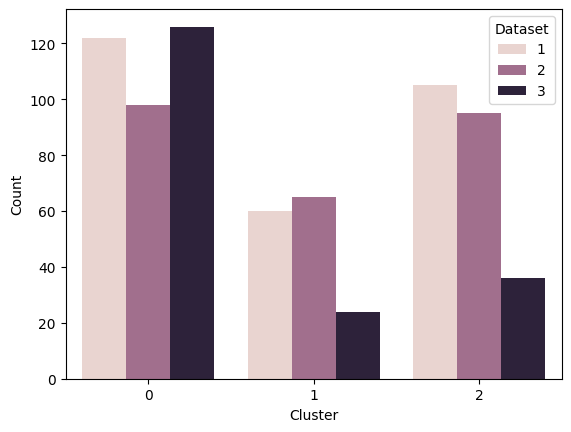

In [120]:
k_data = pd.read_csv('kmeans_mahalanobis_it.csv')
label_count = k_data.groupby(['Dataset','Cluster']).size().reset_index(name='Count')
label_count.to_csv('Kmeans_CLUSTERvsDATASET.csv',index=False)
sns.barplot(x='Cluster',y='Count',hue='Dataset',data=label_count)
plt.savefig('kmeans_plot.png')
plt.show()

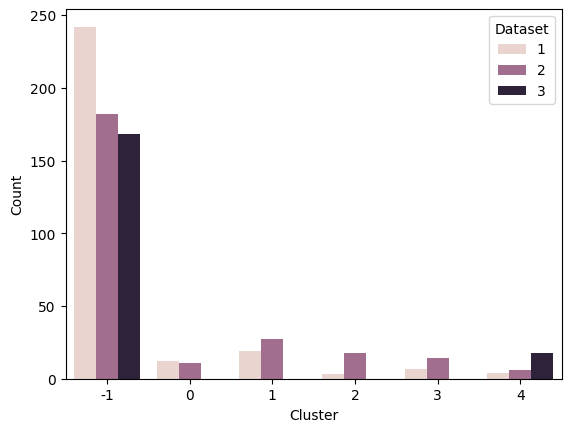

In [121]:
k_data = pd.read_csv('dbscan_mahalanobis_it.csv')
label_count = k_data.groupby(['Dataset','Cluster']).size().reset_index(name='Count')
label_count.to_csv('DBSCANMAH_CLUSTERvsDATASET.csv',index=False)
sns.barplot(x='Cluster',y='Count',hue='Dataset',data=label_count)
plt.savefig('DBSCANMAH_plot.png')
plt.show()


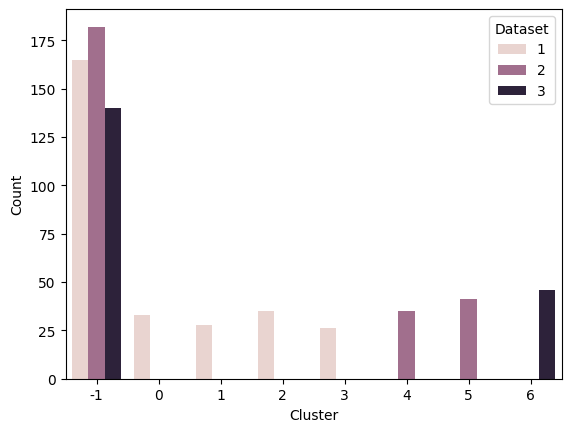

In [122]:
k_data = pd.read_csv('dbscan_hamming_it.csv')
label_count = k_data.groupby(['Dataset','Cluster']).size().reset_index(name='Count')
label_count.to_csv('DBSCAN_CLUSTERvsDATASET.csv',index=False)
sns.barplot(x='Cluster',y='Count',hue='Dataset',data=label_count)
plt.savefig('DBSCAN_plot.png')
plt.show()

In [107]:
def score(Ytest, pred, label, clfname, fname):
    acc = accuracy_score(Ytest, pred)
    pre = precision_score(Ytest, pred)
    rec = recall_score(Ytest, pred)
    f1 = f1_score(Ytest, pred)
    print(f"{label}:\naccuracy: {acc:.2f}\nprecision: {pre:.2f}\nrecall: {rec:.2f}\nfscore: {f1:.2f}\n")
    #scores = [str(clfname),str(label),str(acc),str(pre),str(rec),str(f1)]
    #file_name = './results_new/' + fname + '.csv'
    f = open(fname, "a+")
    #f.write('%s,%s,%0.3f,%f,%f,%f\n' % (clfname,label,acc,pre,rec,f1))
    f.write('%0.3f,%0.3f,%0.3f,%0.3f,' % (acc,pre,rec,f1))
    f.close()
        
    

def find_misclassifications(Ytest, pred, test_data, fname):
    misclassifications = test_data[Ytest['Access'] != pred["Access"]]
    misclassifications.to_csv(fname, index=False)
    return misclassifications

In [108]:
#find count

d_m_data = pd.read_csv('dbscan_mahalanobis_it.csv')
#Show count of each cluster for each dataset
print(d_m_data.groupby(['Dataset','Cluster']).size())
#save the count
m=d_m_data.groupby(['Dataset','Cluster']).size().reset_index(name='Count')
m.to_csv('dbscan_mahalanobis_it_count.csv',index=False)

from numpy import rec
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

def do_testing(file_name,testfile,trainfile,pick=False):
    f = open(file_name+".csv", "w+")
    f.write('clf_name,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,\n')
    f.close()

    if(True):
        name = "Decision Tree"
        clf = DecisionTreeClassifier(random_state=42)
        print(f"[INFO] Training model: {name}")
        f = open(file_name+".csv", "a+")
        f.write('%s,' % (name))
        f.close()

        for i in range(4,5): 
            print(i)
            
            train_data = pd.read_csv(trainfile)
            test_data = pd.read_csv(testfile)
            #print(train_data)
            #print(test_data)
            dataprep_start_time = time.time()
            X_train, X_test, y_train, y_test = GetPreparedData(train_data,test_data,prep_type=i)
            
            #print('Training the classifier')
            if(not pick):
                clf = clf.fit(X_train.to_numpy(), y_train.to_numpy())
            else:
                with open('dt.pkl', 'rb') as f:
                    clf = pickle.load(f)
            
            pred = clf.predict(X_test.to_numpy())
            test_end_time = time.time()
            # print(classification_report(y_test.to_numpy(), pred))
            # print('Data_preptime=%f' %(train_start_time-dataprep_start_time))
            # print('Training_time=%f' %(train_end_time-train_start_time))
            # print('Testing_time=%f' %(test_end_time-train_end_time))
            
            score(y_test.to_numpy(), pred, label=str(i),clfname=name,fname=file_name+".csv")
            pred_train = clf.predict(X_train.to_numpy())
            
            pred = pd.DataFrame(pred,columns=['Access'])
            
            # print(pred, y_test)
            # print("test_data",test_data)

            # print("-"*60)
            #save DT to a figure
            from sklearn.tree import export_graphviz
            print(type(X_test))
            misclass = find_misclassifications(y_test, pred, test_data, f'{file_name}_misclassifications_{i}.csv')
            #Make confusion matrix plot
            cm = confusion_matrix(y_test, pred)
            plt.figure(figsize=(10,7))
            sns.heatmap(cm, annot=True, fmt="d")
            plt.xlabel('Predicted')
            plt.ylabel('Truth')
            plt.title('Confusion Matrix')
            #make it color only leaf nodes
            dot_data = export_graphviz(clf, out_file=f'tree{i}.dot', feature_names = X_train.columns, rounded=True,filled=True, special_characters=True,leaves_parallel=True)
            
            #make tree to json
            
            #pickle this model
            with open(f'dt.pkl', 'wb') as f:
                pickle.dump(clf, f)
            
            X_train, X_test, y_train, y_test = GetPreparedData(train_data,misclass,prep_type=i)
            
            #print paths of misclassifications
    
            leaf_ids = clf.apply(X_test.to_numpy())
            print(leaf_ids)
            # find these indices in the tree
            with open(f"tree{i}.dot", 'r') as file:
                lines = file.readlines()
            
            #make a dict of leaf_ids to count of times it came in leaf_ids
            leaf_count = {}
            for leaf_id in leaf_ids:
                if leaf_id in leaf_count:
                    leaf_count[leaf_id] += 1
                else:
                    leaf_count[leaf_id] = 1
            for leaf_id, count in leaf_count.items():
                for ind,line in enumerate(lines):
                    if line.startswith(f'{leaf_id} [label=<gini'):
                        lines[ind] = line.replace(f'{leaf_id} [label=<gini', f'{leaf_id} [label=<Count={count} gini')
                        print(lines[ind])
                        break
                    
            with open(f"tree{i}_{file_name}.dot", 'w') as file:
                file.writelines(lines)




Dataset  Cluster
1        -1         242
          0          12
          1          19
          2           3
          3           7
          4           4
2        -1         182
          0          11
          1          27
          2          18
          3          14
          4           6
3        -1         168
          4          18
dtype: int64


[INFO] Training model: Decision Tree
4
4:
accuracy: 0.98
precision: 1.00
recall: 0.93
fscore: 0.96

<class 'pandas.core.frame.DataFrame'>
[ 3 35 35 35  3 35 35]
3 [label=<Count=2 gini = 0.0<br/>samples = 693<br/>value = [693, 0]>, fillcolor="#e58139"] ;

35 [label=<Count=5 gini = 0.0<br/>samples = 21<br/>value = [21, 0]>, fillcolor="#e58139"] ;



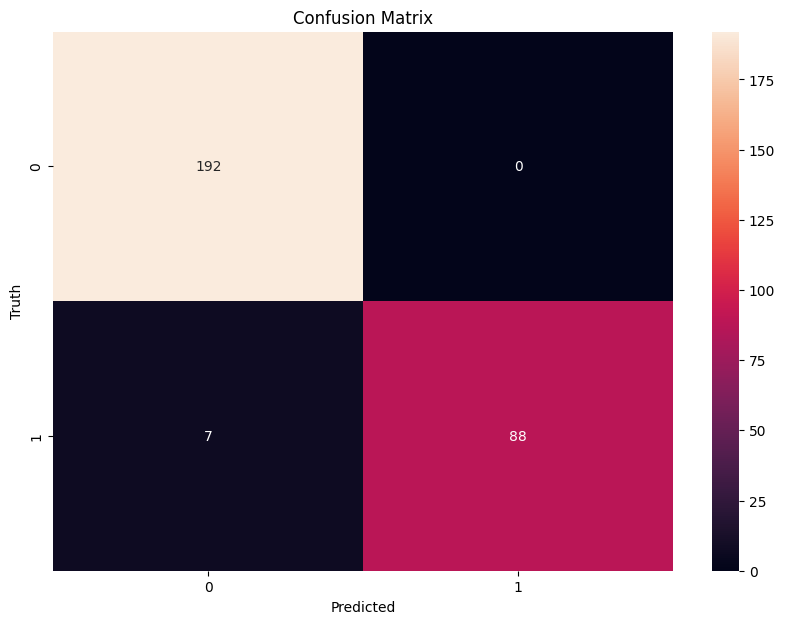

In [109]:
do_testing("change1","it_c1.csv","it_train.csv")

[INFO] Training model: Decision Tree
4
4:
accuracy: 0.96
precision: 0.95
recall: 0.94
fscore: 0.94

<class 'pandas.core.frame.DataFrame'>
[35 35  3  3  3  3  3  3 35  3 35]
35 [label=<Count=4 gini = 0.0<br/>samples = 21<br/>value = [21, 0]>, fillcolor="#e58139"] ;

3 [label=<Count=7 gini = 0.0<br/>samples = 693<br/>value = [693, 0]>, fillcolor="#e58139"] ;



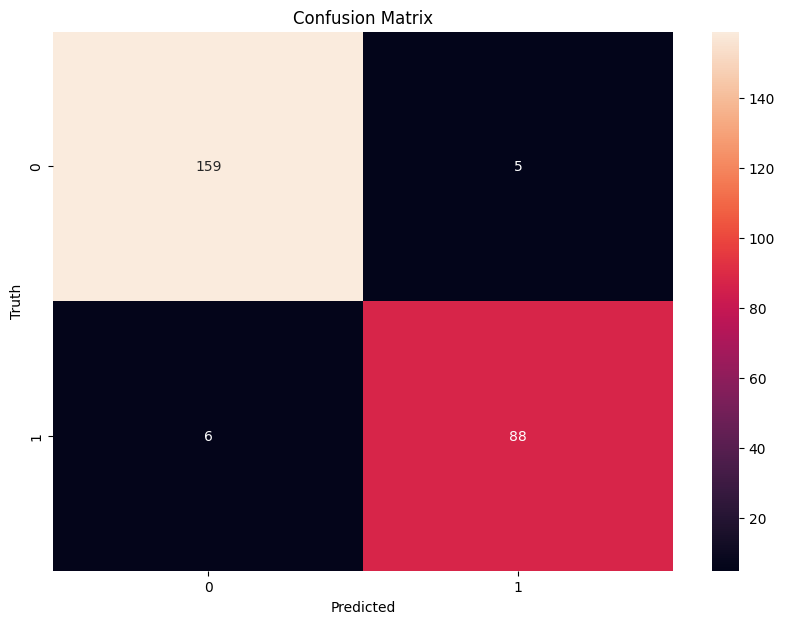

In [110]:
do_testing("change2","it_c2.csv","it_train.csv")

[INFO] Training model: Decision Tree
4
4:
accuracy: 0.91
precision: 0.97
recall: 0.87
fscore: 0.92

<class 'pandas.core.frame.DataFrame'>
[20 20  8 20 20 20 20 20 20 20 20 35 35 35 35 35 35]
20 [label=<Count=10 gini = 0.0<br/>samples = 10<br/>value = [10, 0]>, fillcolor="#e58139"] ;

8 [label=<Count=1 gini = 0.0<br/>samples = 34<br/>value = [34, 0]>, fillcolor="#e58139"] ;

35 [label=<Count=6 gini = 0.0<br/>samples = 21<br/>value = [21, 0]>, fillcolor="#e58139"] ;



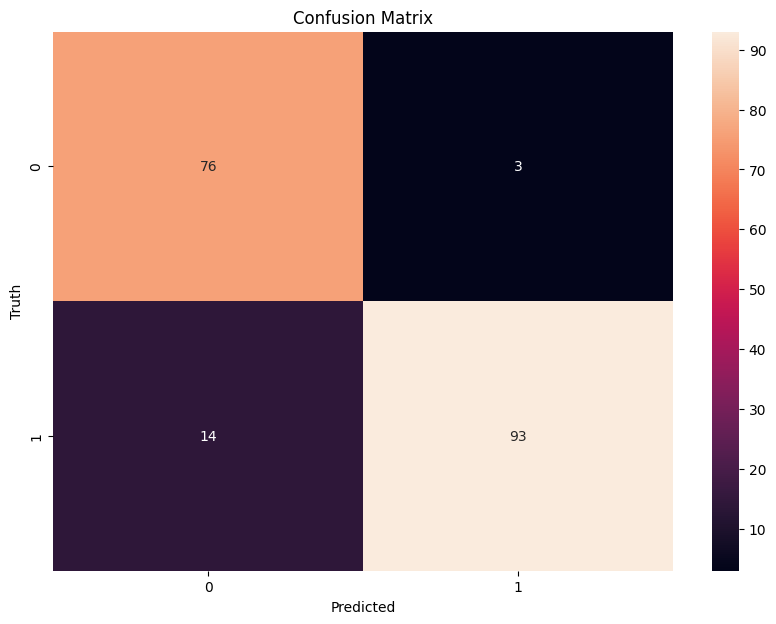

In [111]:
do_testing("change3","it_c3.csv","it_train.csv")

In [112]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import seaborn as sns

def mahalanobis_distance(x=None, data=None, cov=None):
    x_mu = x - np.mean(data)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left_term, x_mu.T)
    return mahal



def trainfortest(testfile,trainfile):
    """Find neearest nearest train points for train points, hamming distance"""
    test_data = pd.read_csv(testfile)
    test_dat = pd.read_csv(testfile)
    train_data = pd.read_csv(trainfile)
    train_dat = pd.read_csv(trainfile)
    #reset index for all
    test_data.reset_index(drop=True, inplace=True)
    train_data.reset_index(drop=True, inplace=True)
    train_dat.reset_index(drop=True, inplace=True)
    test_dat.reset_index(drop=True, inplace=True)
    
    X_train, X_test, y_train, y_test = GetPreparedData(train_dat,test_dat,prep_type=1)
    print(X_test)
    #Convert all to integers all columns
    X_train = X_train.astype(int)
    X_test = X_test.astype(int)
    #Reset index for X_train
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    
    min_ham = pd.DataFrame(columns = X_train.columns)

    for i in range(X_test.shape[0]):
        # print(X_train)
        cov = np.cov(X_train.T)
        dist = mahalanobis_distance(x=X_test.iloc[i],data=X_train,cov=cov)
        train_row=train_data.iloc[np.argmin(dist)]
        # print(train_row)
        min_ham = min_ham._append(train_row,ignore_index=True)
    min_ham.reset_index(drop=True, inplace=True)
    # print(min_ham)
    test_data = test_data.join(min_ham, how='outer', rsuffix='_train')
    test_data.to_csv(testfile,index=False)
    #append these columns to the test_data
    #replace names of columns in min_ham to train columns

In [113]:
trainfortest('change1_misclassifications_4.csv','it_train.csv')
trainfortest('change2_misclassifications_4.csv','it_train.csv')
trainfortest('change3_misclassifications_4.csv','it_train.csv')

{'NotA': -1, 0: 0, 'YES': 1, 'NO': 0, 'HR MANAGER': 1, 'FINANCE MANAGER': 2, 'CTO': 3, 'CEO': 4, 'DESIGNER': 5, 'PROGRAMMER': 6, 'SDE': 7, 'PROJECT_MANAGER': 8, 'PROJECT_LEADER': 9, 'NETWORK_ENGINEER': 10, 'DATABASE_ENGINEER': 11, 'IT_MANAGER': 12, 'PRINCIPAL': 13, 'P1': 14, 'P2': 15, 'P4': 16, 'P5': 17, 'P6': 18, 'P7': 19, 'P3': 20, 'HR': 21, 'FINANCE': 22, 'ADMINISTRATION': 23, 'DEVELOPMENT': 24, 'TECHNICAL': 25, 'junior': 26, 'senior': 27, 'intermediate': 28, 'SALARY_DETAIL': 29, 'CLIENT_DETAIL': 30, 'EMP_DETAIL': 31, 'PROJECT_DETAIL': 32, 'PROJECT_COST': 33, 'SERVER': 34, 'DATABASE': 35, 'NETWORK_SETUP': 36, 'low': 37, 'medium': 38, 'high': 39}
   DESIGNATION  Project_name  Department  Experience_level  Resource  \
0            5            20          24                26        34   
1           13            -1          24                26        30   
2           13            -1          24                26        30   
3           13            -1          24               

----------------------------------------
{-1: 17, 4: 5, 6: 6}


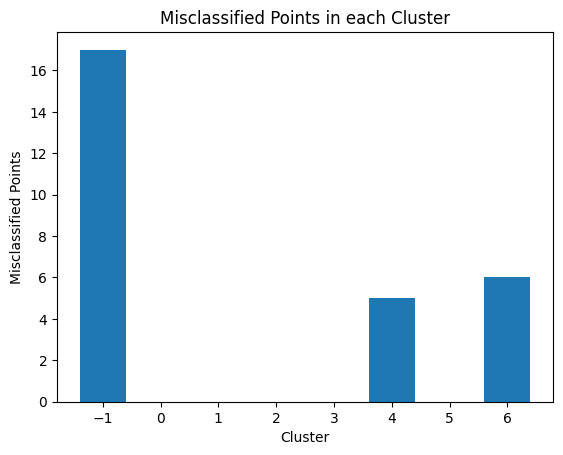

In [114]:



#find the cluster of misclassified points
#find number of points misclassified in each cluster
# plot misclassified points in each cluster against the cluster
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import seaborn as sns

import matplotlib.pyplot as plt

mis = {}

def find_cluster(file1,file2):
    misclassified = pd.read_csv(file1)
    misclassified = misclassified.reset_index(drop=True)
    test_data = pd.read_csv(file2)
    test_data = test_data.reset_index(drop=True)
    #find type of columns in both
    real_columns = test_data.columns
    real_columns = real_columns.drop(['Cluster','Dataset'])
    for col in real_columns:
        if type(misclassified[col][0]) != type(test_data[col][0]):
            #Encode both to string
            misclassified[col] = misclassified[col].astype(str)
            test_data[col] = test_data[col].astype(str)
    
    #find and print cluster of misclassified points
    for ind,row in misclassified.iterrows():
        for ind2,row2 in test_data.iterrows():
            same = True
            for attr in real_columns:
                if row[attr] != row2[attr]:
                    # print(row[attr],row2[attr])
                    same = False
                    break
            if same:
                if row2['Cluster'] not in mis:
                    mis[row2['Cluster']] = 1
                else:
                    mis[row2['Cluster']] += 1
                break

find_cluster('change2_misclassifications_4.csv','dbscan_hamming_it.csv')
print("-"*40)
find_cluster('change3_misclassifications_4.csv','dbscan_hamming_it.csv')
print(mis)
plt.bar(mis.keys(),mis.values())
plt.xlabel('Cluster')
plt.ylabel('Misclassified Points')
plt.title('Misclassified Points in each Cluster')
plt.savefig('misclassified_cluster_DT.png')
plt.show()
#Save plot to file


[INFO] Training model: ArtificalNeuralNetwork
4
4:
accuracy: 0.76
precision: 0.68
recall: 0.55
fscore: 0.60

[INFO] Training model: ArtificalNeuralNetwork
4
4:
accuracy: 0.83
precision: 0.76
recall: 0.77
fscore: 0.76

[INFO] Training model: ArtificalNeuralNetwork
4
4:
accuracy: 0.83
precision: 0.76
recall: 0.77
fscore: 0.76



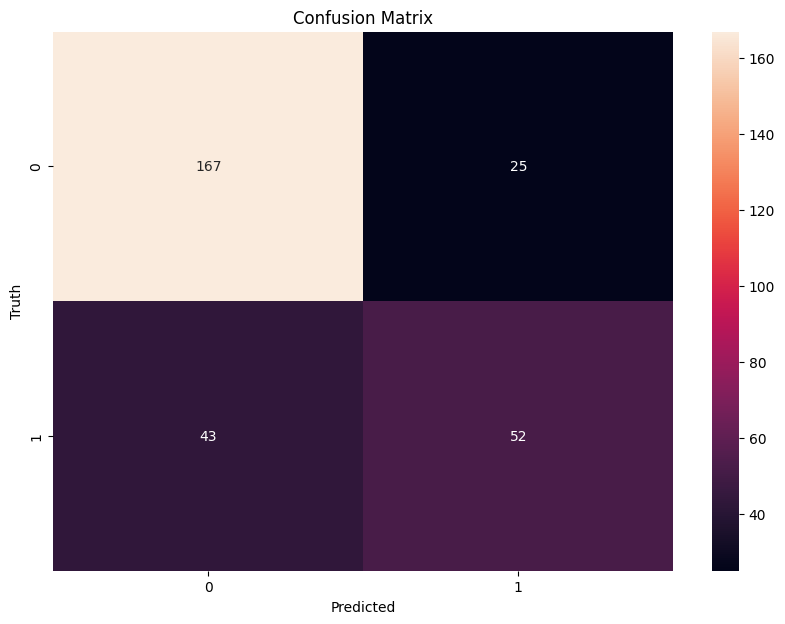

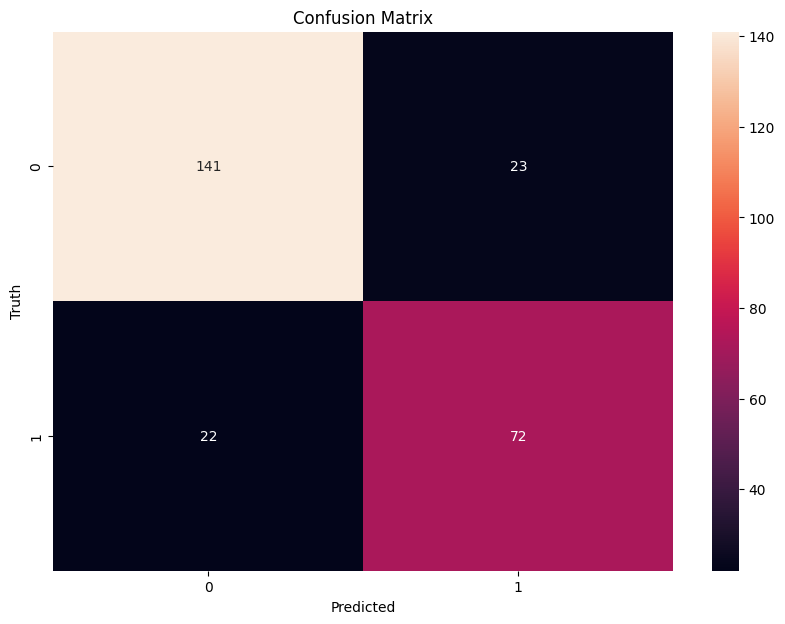

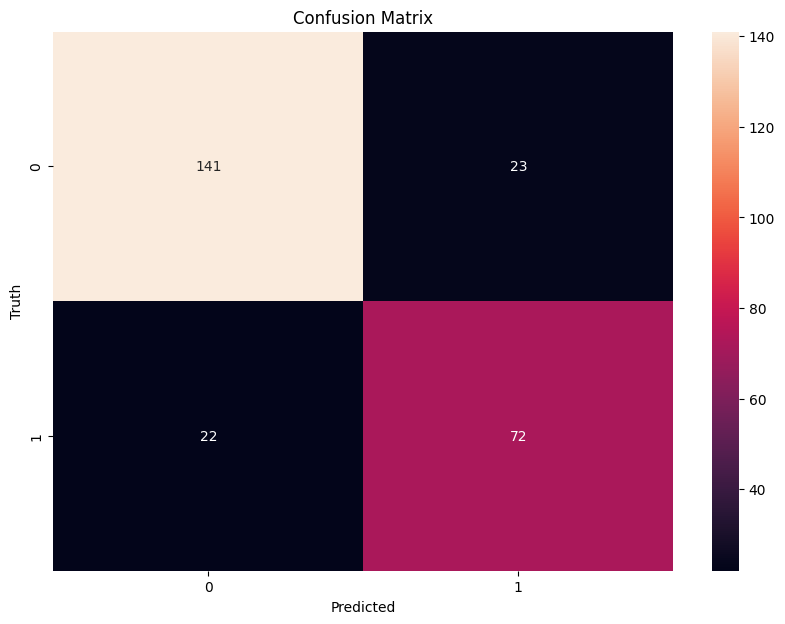

In [115]:

from numpy import rec
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

def do_testing(file_name,testfile,trainfile,pick=False):
    f = open(file_name+".csv", "w+")
    f.write('clf_name,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,\n')
    f.close()

    if(True):
        name = "ArtificalNeuralNetwork"
        clf = MLPClassifier(hidden_layer_sizes=30, max_iter=1500,random_state=42)
        print(f"[INFO] Training model: {name}")
        f = open(file_name+".csv", "a+")
        f.write('%s,' % (name))
        f.close()

        for i in range(4,5): 
            print(i)
            
            train_data = pd.read_csv(trainfile)
            test_data = pd.read_csv(testfile)
            dataprep_start_time = time.time()
            X_train, X_test, y_train, y_test = GetPreparedData(train_data,test_data,prep_type=i)
            
            #print('Training the classifier')
            if(not pick):
                clf = clf.fit(X_train.to_numpy(), y_train.to_numpy())
            else:
                with open('ANN.pkl', 'rb') as f:
                    clf = pickle.load(f)
            
            pred = clf.predict(X_test.to_numpy())
            test_end_time = time.time()
            
            score(y_test.to_numpy(), pred, label=str(i),clfname=name,fname=file_name+".csv")
            pred_train = clf.predict(X_train.to_numpy())
            
            pred = pd.DataFrame(pred,columns=['Access'])
            
            #save DT to a figure
            from sklearn.tree import export_graphviz
            # print(type(X_test))
            misclass = find_misclassifications(y_test, pred, test_data, f'{file_name}_misclassifications_{i}_ANN.csv')
            #Make confusion matrix plot
            cm = confusion_matrix(y_test, pred)
            plt.figure(figsize=(10,7))
            sns.heatmap(cm, annot=True, fmt="d")
            plt.xlabel('Predicted')
            plt.ylabel('Truth')
            plt.title('Confusion Matrix')
            with open(f'ANN.pkl', 'wb') as f:
                pickle.dump(clf, f)

do_testing('change1','it_c1.csv','it_train.csv')
#three msiclassifications
do_testing('change2','it_c2.csv','it_train.csv',False)

do_testing('change3','it_c2.csv','it_train.csv',False)
#find the cluster of misclassified points


----------------------------------------
{-1: 64, 5: 12, 4: 14}
   Cluster  Misclassified
0       -1             64
1        5             12
2        4             14


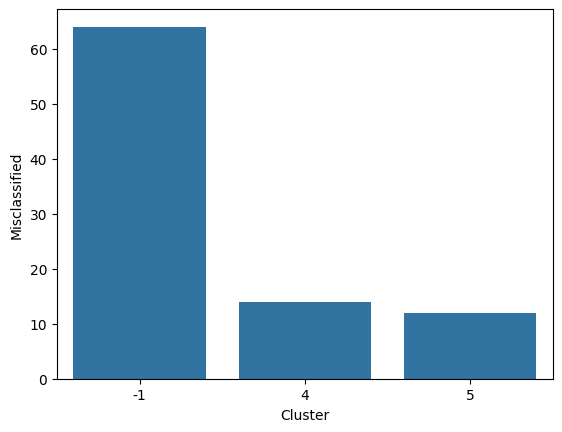

In [116]:
mis = {}

def find_cluster(file1,file2):
    misclassified = pd.read_csv(file1)
    misclassified = misclassified.reset_index(drop=True)
    test_data = pd.read_csv(file2)
    test_data = test_data.reset_index(drop=True)
    #find type of columns in both
    real_columns = test_data.columns
    real_columns = real_columns.drop(['Cluster','Dataset'])
    for col in real_columns:
        if type(misclassified[col][0]) != type(test_data[col][0]):
            #Encode both to string
            misclassified[col] = misclassified[col].astype(str)
            test_data[col] = test_data[col].astype(str)
    
    #find and print cluster of misclassified points
    for ind,row in misclassified.iterrows():
        for ind2,row2 in test_data.iterrows():
            same = True
            for attr in real_columns:
                if row[attr] != row2[attr]:
                    # print(row[attr],row2[attr])
                    same = False
                    break
            if same:
                if row2['Cluster'] not in mis:
                    mis[row2['Cluster']] = 1
                else:
                    mis[row2['Cluster']] += 1
                break

find_cluster('change2_misclassifications_4_ANN.csv','dbscan_hamming_it.csv')
print("-"*40)
find_cluster('change3_misclassifications_4_ANN.csv','dbscan_hamming_it.csv')
print(mis)
#make the =m int 
for key in mis:
    mis[key] = [mis[key]]
mis = pd.DataFrame.from_dict(mis)
mis = mis.T
mis.reset_index(drop=False, inplace=True)
mis.columns = ['Cluster','Misclassified']
print(mis)
mis.to_csv('misclassified_cluster.csv',index=False)

#plot the misclassified points
sns.barplot(x='Cluster',y='Misclassified',data=mis)
plt.savefig('misclassified_clusterANN.png')
plt.show()
#Save the Plot
